# The Emergence of Us and Them by Using Cognitive Biases

This article talks about how little it is needed in order to create the groups from the homogenious agents. The only think needed is reciprocity (if you help me, I will help you) and transitivity (checking the social relationships between people one knows).

The analysis was based on the following article:

* Gray, K., Rand, D. G., Ert, E., Lewis, K., Hershman, S., & Norton, M. I. (2014). The emergence of “us and them” in 80 lines of code: Modeling group genesis in homogeneous populations. Psychological science, 25(4), 982-990. https://dash.harvard.edu/bitstream/handle/1/28538429/gray%2Crand%2Cnorton%2Cet%20al_the-emergence-of-us-and-them.pdf?sequence=1

First, let us import the libaries, needed in this analysis. 

First, the mesa libaries for agent based modeling.

In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation

Then the libaries, connected with networks.

In [2]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import community

The the additional libaries, that are needed for vizualization.

In [3]:
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

And other libaries, that are needed in the model.

In [4]:
import random

Here I am defining the list of colors, that will help me later with vizualization.

In [5]:
list_of_colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())
list_of_colors.remove("black")

First, we create the model. It is a basic model, with agents being choosen in random order each turn.

In [6]:
class GroupCreationModel(Model):
    def __init__(self, N, r, t):
        self.num_agents = N
        self.schedule = RandomActivation(self)

        for i in range(self.num_agents):
            a = HumanAgent(i, self, r, t)
            self.schedule.add(a)
            
    def step(self):
        self.schedule.step()

And here we define the agents. They have the ability to keep track of relationships. And then each time, they can decide, whenever they want to interact with an agent.

In [7]:
class HumanAgent(Agent):
    
    def __init__(self, name, model, r, t):
        super().__init__(name, model)
        self.name = name
        self.all_relationships = dict()
        #how big the effect of reciprocity is
        self.r = r
        #how big the effect of transitivity is
        self.t = t
        
    def step(self):
        #each time, the agent randomlly chooses a pratner
        other_agent = random.choice(self.model.schedule.agents)
        #if it chooses itself, nothing happens
        if other_agent.name == self.name:
            return None
        #if the other agent is not yet in a relationship with this agent, it is added with neutral relationship
        if not other_agent.name in self.all_relationships:
            self.all_relationships[other_agent.name] = 0.5
            other_agent.all_relationships[self.name] = 0.5
        #players interact, if they need to invest less energy, then the strength of relationship
        #the stronger the relationship, the more energy, they are willing to invest
        do_players_interact = random.uniform(0,1) < self.all_relationships[other_agent.name]
        #if they interact, they both decide, if they want to cooperate.
        #the stronger relationship, the more likely they are to cooperate
        if do_players_interact:
            random_self = random.uniform(0,1)
            random_other = random.uniform(0,1)
            if random_self < self.all_relationships[other_agent.name] and random_other < self.all_relationships[other_agent.name]:
                #if they both cooperate, they increase their relationship
                new_distance = 1 - (1 - self.all_relationships[other_agent.name])/self.r
                self.all_relationships[other_agent.name] = new_distance
                other_agent.all_relationships[self.name] = new_distance
                #they also check all the other agents, to see if they can find some more info about other people
                for a in self.model.schedule.agents:
                    if a.name in self.all_relationships and a.name in other_agent.all_relationships:
                        self_difference = abs(0.5 - self.all_relationships[a.name])
                        other_difference = abs(0.5 - other_agent.all_relationships[a.name])
                        if self_difference > other_difference:
                            change = (self.all_relationships[a.name] - other_agent.all_relationships[a.name])/self.t
                            other_agent.all_relationships[a.name] += change
                            a.all_relationships[other_agent.name] += change
                        elif other_difference > self_difference:
                            change = (other_agent.all_relationships[a.name] - self.all_relationships[a.name])/self.t
                            self.all_relationships[a.name] += change
                            a.all_relationships[self.name] += change
            elif random_self > self.all_relationships[other_agent.name] and random_other > self.all_relationships[other_agent.name]:
                #if they both deflect, they decrease their relationship
                new_distance = 0 + (0 + self.all_relationships[other_agent.name])/self.r
                self.all_relationships[other_agent.name] = new_distance
                other_agent.all_relationships[self.name] = new_distance
            else:
                #otherwise nothing happens
                pass

Here we now start the model, we defined up there.

In [8]:
model = GroupCreationModel(30, 2, 2)

Now we run the model for 2000 steps.

In [9]:
for i in range(100):
    model.step()

Let us now check, what is the strength of the relationships between different agents in a aggregate manner.

(array([ 5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 25.]),
 array([0.02102997, 0.11892697, 0.21682397, 0.31472097, 0.41261798,
        0.51051498, 0.60841198, 0.70630899, 0.80420599, 0.90210299,
        0.99999999]),
 <a list of 10 Patch objects>)

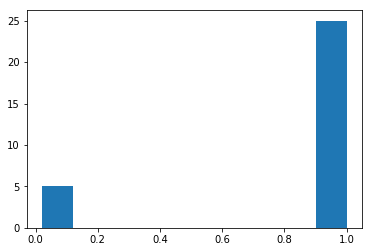

In [10]:
plt.hist([[rel for node, rel in a.all_relationships.items()][0] for a in model.schedule.agents])

Here we define, how strong the relationship needs to be, in order to be included on the graph. 0.5 is neutral, less than that, it is a negative relationship and higher than that is a positive relationship.

In [11]:
relationship_strength = 0.8

Now we get all the relationships, that are above that strength, for the final graph. 

In [12]:
relationships = []
values = []
for a in model.schedule.agents:
    for node, rel in a.all_relationships.items():
        if rel > relationship_strength:
            relationships.append((a.name, node, {"weight": rel}))

And here is the number of relationships. 

In [13]:
len(relationships)

812

Here we create a graph of agents and their positive relationships. 

In [14]:
G = nx.Graph()
G.add_nodes_from([a.name for a in model.schedule.agents])
G.add_edges_from(relationships)

The next one uses one of the algoritms, to try and finds the groups in the network. 

In [15]:
groups = community.best_partition(G, weight='weight')
groups_names = sorted(list(set(groups.values())))

In [16]:
len(groups_names)

2

And then, here I can vizualize the networks, where the defined groups are colored differentlly.

/usr/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


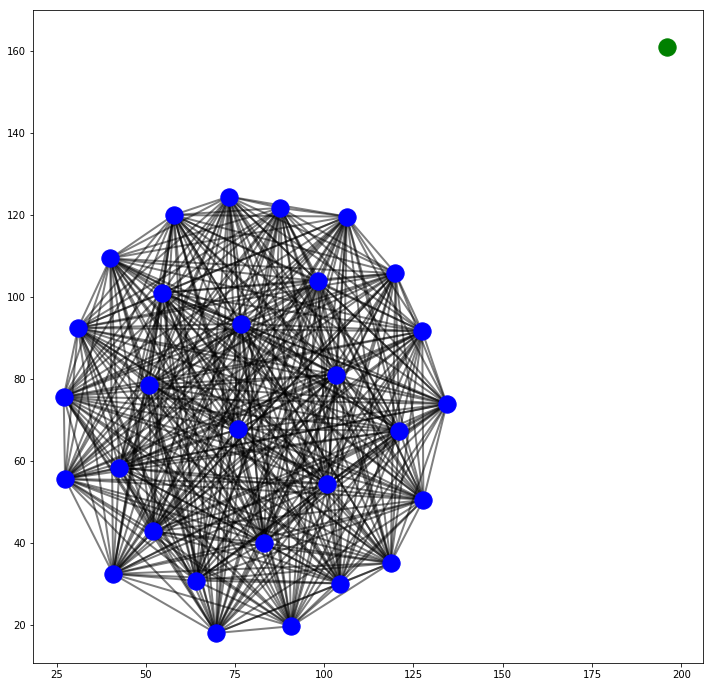

In [17]:
plt.figure(3,figsize=(12,12)) 
pos = graphviz_layout(G)
for i, group_name in enumerate(groups_names):
    nx.draw_networkx_nodes(G,
                           pos,
                           nodelist=[node for node, group in groups.items() if group == group_name],
                           node_color=list_of_colors[i],
                           )
nx.draw_networkx_edges(G,pos,
                       edgelist=G.edges(),
                       width=2,
                       alpha=0.5,
                       edge_color="black")